<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 Random Forest Model

_Authors: Joel Quek (SG)_

# Problem Statement

NLP Model to match posts from r/investing, r/stockmarket, r/wallstreetbets

[Reddit Post Classification](https://towardsdatascience.com/reddit-post-classification-b70258d6affe)

[Text Cleaning for NLP: A Tutorial](https://monkeylearn.com/blog/text-cleaning/) [Important]

# Exploratory Data Analysis

## Import Libraries

In [2]:
#All libraries used in this project are listed here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import re
from bs4 import BeautifulSoup 

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, make_scorer, recall_score, precision_score,accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score


# Open Scraped Datasets

The jupytyer notebooks for scraping are 'reddit-scrape.ipynb' and 'wallstreetbets-scrape.ipynb'

In [3]:
investing_df = pd.read_csv('datasets/investing.csv')
stockmarket_df = pd.read_csv('datasets/stockmarket.csv')

## r/investing

In [4]:
investing_df.shape

(7995, 75)

In [5]:
investing_df.iloc[investing_df.shape[0]-1]['created_utc']

# GMT: Friday, July 8, 2022 9:18:46 AM

1657271926

In [6]:
# investing_df=investing_df[['subreddit', 'author', 'selftext', 'title']]
investing_df=investing_df[['subreddit', 'selftext', 'title']]
investing_df.head()

,subreddit,selftext,title
0,investing,"Hey guys, I’m a 22 year old male, I grew up wi...",Help a young man out would ya?
1,investing,[removed],Treasury bonds is it a good idea to buy
2,investing,[removed],How to buy treasury bonds? Is treasury’s direc...
3,investing,[removed],Early Exercise of Stock Options
4,investing,Hello Redditors 👋 \n\nI work as a Investment C...,Alternative Investments -


In [7]:
investing_df1=investing_df[['subreddit', 'selftext']]
investing_df2=investing_df[['subreddit', 'title']]

investing_df1.rename(columns={'selftext':'Text'},inplace=True)
investing_df2.rename(columns={'title':'Text'},inplace=True)

C:\Users\redoc\AppData\Local\Temp\ipykernel_104416\2530647326.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  investing_df1.rename(columns={'selftext':'Text'},inplace=True)
C:\Users\redoc\AppData\Local\Temp\ipykernel_104416\2530647326.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  investing_df2.rename(columns={'title':'Text'},inplace=True)


In [8]:
investing_df = pd.concat([investing_df1, investing_df2], ignore_index=True,axis=0)
investing_df.head()

,subreddit,Text
0,investing,"Hey guys, I’m a 22 year old male, I grew up wi..."
1,investing,[removed]
2,investing,[removed]
3,investing,[removed]
4,investing,Hello Redditors 👋 \n\nI work as a Investment C...


In [9]:
investing_df.shape

(15990, 2)

# * REMOVE AUTHOR AND CONCAT TITLE AND SELFTEXT INTO ONE COLUMN

## r/stockmarket

In [10]:
stockmarket_df.shape

(7494, 81)

In [11]:
stockmarket_df.iloc[stockmarket_df.shape[0]-1]['created_utc']

# GMT: Wednesday, July 13, 2022 2:13:58 AM

1657678438

In [12]:
stockmarket_df=stockmarket_df[['subreddit', 'author', 'selftext', 'title']]
stockmarket_df.head()

,subreddit,author,selftext,title
0,StockMarket,zitrored,NaN,Looking for the next exogenous event that take...
1,StockMarket,CompetitiveMission1,[Link to the full article (4 min read)](https:...,China stocks notch trillion-dollar gain on hop...
2,StockMarket,jaltrading21,NaN,Get ready for some economic news and company e...
3,StockMarket,ShabbyShamble,NaN,Market Recap! Bear Market Blues! Palantir (PLT...
4,StockMarket,PriceActionHelp,NaN,Why it's not smart to rely on the RSI divergence


In [13]:
stockmarket_df1=stockmarket_df[['subreddit', 'selftext']]
stockmarket_df2=stockmarket_df[['subreddit', 'title']]

stockmarket_df1.rename(columns={'selftext':'Text'},inplace=True)
stockmarket_df2.rename(columns={'title':'Text'},inplace=True)

C:\Users\redoc\AppData\Local\Temp\ipykernel_104416\961984385.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockmarket_df1.rename(columns={'selftext':'Text'},inplace=True)
C:\Users\redoc\AppData\Local\Temp\ipykernel_104416\961984385.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockmarket_df2.rename(columns={'title':'Text'},inplace=True)


In [14]:
stockmarket_df = pd.concat([stockmarket_df1, stockmarket_df2], ignore_index=True,axis=0)
stockmarket_df.head()

,subreddit,Text
0,StockMarket,NaN
1,StockMarket,[Link to the full article (4 min read)](https:...
2,StockMarket,NaN
3,StockMarket,NaN
4,StockMarket,NaN


In [15]:
stockmarket_df.shape

(14988, 2)

# Final Cleaning 

## Handling Missing Values

In [16]:
# investing_df['selftext']=investing_df['selftext'].fillna('')
# stockmarket_df['selftext']=stockmarket_df['selftext'].fillna('')


## * DROPNA BECAUSE THERE IS NO WAY TO IMPUTE

In [17]:
investing_df=investing_df.dropna()
stockmarket_df=stockmarket_df.dropna()

In [18]:
investing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15964 entries, 0 to 15989
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  15964 non-null  object
 1   Text       15964 non-null  object
dtypes: object(2)
memory usage: 374.2+ KB


In [19]:
stockmarket_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11181 entries, 1 to 14987
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  11181 non-null  object
 1   Text       11181 non-null  object
dtypes: object(2)
memory usage: 262.1+ KB


## Concatenate both Dataframes

In [20]:
df = pd.concat([investing_df,stockmarket_df],ignore_index=True)

In [21]:
df.shape

(27145, 2)

In [22]:
df['subreddit'].value_counts()

investing      15964
StockMarket    11181
Name: subreddit, dtype: int64

In [23]:
df.head()

,subreddit,Text
0,investing,"Hey guys, I’m a 22 year old male, I grew up wi..."
1,investing,[removed]
2,investing,[removed]
3,investing,[removed]
4,investing,Hello Redditors 👋 \n\nI work as a Investment C...


## Lowercase

In [24]:
df['Text']=[c.lower() for c in df['Text']]

## * DONT NECESSARILY NEED TO REMOVE STOP WORDS [DEPENDS ON CONTEXT]

## Remove Non Letters

In [25]:
df['Text']=df['Text'].map(lambda x: re.sub("[^a-zA-Z]", " ", x)) 

## Remove Stop Words

In [26]:
def remove_stop_words(text):
    stops = stopwords.words('english')
    stops=set(stops)
    text = " ".join([word for word in text.split() if word not in (stops)])
    # text = [w for w in text if not w in stops]

    return text

In [27]:
df['Text']=df['Text'].map(lambda x: remove_stop_words(x))

## Hot Encode Target Vector

In [28]:
df['subreddit']=df['subreddit'].map({'investing': 0, 'StockMarket': 1})

In [29]:
df.head()

,subreddit,Text
0,0,hey guys year old male grew greatest backgroun...
1,0,removed
2,0,removed
3,0,removed
4,0,hello redditors work investment consultant bou...


## Remove Rows where Text is 'removed'

In [30]:
df=df[df['Text'].str.contains('removed')==False]

In [31]:
X=df['Text']
y=df['subreddit']

In [32]:
y.value_counts(normalize = True)

0    0.5521
1    0.4479
Name: subreddit, dtype: float64

In [33]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

----

# Count Vectorizer

In [34]:
# Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer()

In [35]:
X_train

25325          regencell rgc performing stock among us ipo
26350    help understanding impairment calculation mstr...
14194                              beginner investor start
366      turning days saving money invest wondering goo...
12184                         new discord server investing
                               ...                        
11331                            right idea passive income
15799                                help boy graduate lfg
4668     hey first time posting working weekend job cou...
15879                       investing life insurance money
16345    elon musk friday p et close deal twitter trial...
Name: Text, Length: 12924, dtype: object

In [36]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer()

In [37]:
# Transform the corpus.
X_train = cvec.transform(X_train) 
# transform creates the vector of words

In [38]:
X_train.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [39]:
X_train.shape

(12924, 23993)

In [40]:
print(X_train)

  (0, 795)	1
  (0, 10963)	1
  (0, 15359)	1
  (0, 17258)	1
  (0, 17790)	1
  (0, 19966)	1
  (0, 22271)	1
  (1, 837)	1
  (1, 2929)	1
  (1, 6361)	1
  (1, 9629)	1
  (1, 10318)	1
  (1, 13548)	1
  (1, 21951)	1
  (2, 1925)	1
  (2, 10905)	1
  (2, 19839)	1
  (3, 961)	1
  (3, 1032)	1
  (3, 2401)	1
  (3, 5047)	1
  (3, 5050)	1
  (3, 6653)	1
  (3, 7556)	1
  (3, 9020)	2
  :	:
  (12923, 21078)	1
  (12923, 21229)	2
  (12923, 21247)	4
  (12923, 21514)	8
  (12923, 21580)	1
  (12923, 21651)	1
  (12923, 21722)	10
  (12923, 21727)	2
  (12923, 21916)	1
  (12923, 22059)	3
  (12923, 22069)	1
  (12923, 22076)	2
  (12923, 22202)	1
  (12923, 22332)	4
  (12923, 22974)	1
  (12923, 23010)	1
  (12923, 23082)	1
  (12923, 23090)	2
  (12923, 23126)	1
  (12923, 23149)	1
  (12923, 23267)	1
  (12923, 23433)	1
  (12923, 23445)	5
  (12923, 23536)	3
  (12923, 23797)	1


In [41]:
cvec.get_feature_names()[1000:1010]

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['apms',
 'apnews',
 'apo',
 'apocalypse',
 'apocalyptic',
 'apog',
 'apolitical',
 'apollo',
 'apologies',
 'apologize']

In [42]:
# Transform test
X_test = cvec.transform(X_test) # we fit the CountVectorizer data based on the X_Train and use that model to transform T_Test

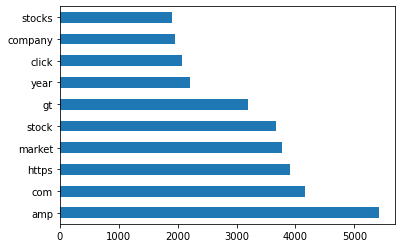

In [43]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh'); # head(10) gives top ten words

## Baseline Accuracy

In [44]:
y_test.value_counts(normalize=True)

0    0.552152
1    0.447848
Name: subreddit, dtype: float64

Baseline is 0.516. If I generate a random model for class 0, it should return around 0.516 

# Reinstantiate Train and Test Data [Should I do this for random forest?]

To avoid error of instantiating/fitting count vectorizer down below [IMPORTANT]

In [50]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

# 1(a) Random Forest with Count Vectorizer

In [46]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Random Forest (estimator)

pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [48]:
cross_val_score(pipe1, X_train, y_train, cv=5)

KeyboardInterrupt: 

Basecase without hyperparameter tuning

In [216]:
# ii. Fit into model
pipe1.fit(X_train, y_train)

# Training score
print(pipe1.score(X_train, y_train))

0.989322191272052


In [217]:
# Test score
print(pipe1.score(X_test, y_test))

0.7332704995287465


## Random Forest Versus Extra Trees [Comparison]

In [218]:
rf = RandomForestClassifier(n_estimators=100)

In [219]:
et = ExtraTreesClassifier(n_estimators=100)

## Model Evaluation [Random Forest Versus Extra Trees]
---

Which one has a higher `cross_val_score`?

In [220]:
cross_val_score(rf, X_train_df, y_train, cv=5).mean()

0.7309656508434587

Took 17 minutes for Random Forests

In [221]:
cross_val_score(et, X_train_df, y_train, cv=5).mean()

0.7272516183506895

Took 58 minutes for Extra Trees

## Gridsearch with Count Vectorizer

### Applying Count Vectorizer on Training Data 

In [222]:
# X_train = cvec.transform(X_train) 

In [51]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), # change data set to hot encoded array
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

AttributeError: 'Series' object has no attribute 'todense'

In [52]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

## USE PIPE1 INSTEAD OF RF FOR THE GRIDSEARCH

In [53]:
X_train_df

,aa,aaa,aab,aabb,aadc,aadi,aae,aaed,aafac,aaigf,...,zx,zxymqpw,zy,zyak,zymergen,zyou,zz,zzobk,zzppzw,zzrsbp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12919,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
y_train

25325    1
26350    1
14194    0
366      0
12184    0
        ..
11331    0
15799    0
4668     0
15879    0
16345    1
Name: subreddit, Length: 12924, dtype: int64

In [55]:
rf_params = {
    #'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    #'cvec__min_df': [0.05],
    #'cvec__max_df': [0.95],
    #'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5], # max_depth is the longest path
}
gs = GridSearchCV(pipe1, param_grid=rf_params, cv=5) # USE PIPE1 INSTEAD


In [ ]:
gs.fit(X_train, y_train) # or X_train_df ?
print(gs.best_score_)
gs.best_params_

27 min

---

In [238]:
gs.score(X_train, y_train)

0.989322191272052

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

In [240]:
# Transform test
# X_test = cvec.transform(X_test) # we fit the CountVectorizer data based on the X_Train and use that model to transform T_Test

## DONT NEED TO HAVE THE KEY WORDS AGAIN FOR TEST DATA

In [244]:
gs.score(X_test, y_test) # or X_test_df ? 

0.736569274269557

## BOOLEAN MASKING ON DATAFRAME 

WITH ACTUAL TEST TARGET AND PREDICTED VALUES TO FIND OUT THE FALSE POSITIVES AND FALSE NEGATIVES

In [246]:
preds = gs.predict(X_test)

In [247]:
preds = pd.Series(preds)

print(type(preds))
preds

<class 'pandas.core.series.Series'>


0       0
1       0
2       0
3       1
4       1
       ..
6361    1
6362    1
6363    1
6364    0
6365    1
Length: 6366, dtype: int64

In [248]:
print(type(X_test))

X_test.head()

<class 'pandas.core.series.Series'>


8406           traditional roth tax bracket actually lower
14781          daily general discussion advice thread july
7471     hi wondering would good place put pitch invest...
25723    bed bath amp beyond inc bbby one heavily short...
20041                               go well morning coffee
Name: Text, dtype: object

In [249]:
print(type(y_test))

y_test

<class 'pandas.core.series.Series'>


8406     0
14781    0
7471     0
25723    1
20041    1
        ..
13748    0
21637    1
20291    1
14025    0
22170    1
Name: subreddit, Length: 6366, dtype: int64

In [250]:
df = pd.concat([X_test, y_test], axis=1).reset_index()


In [251]:
df = pd.concat([df, preds], axis=1).reset_index()
# df.drop(['level_0','index'],axis=1, inplace=True)
df

,level_0,index,Text,subreddit,0
0,0,8406,traditional roth tax bracket actually lower,0,0
1,1,14781,daily general discussion advice thread july,0,0
2,2,7471,hi wondering would good place put pitch invest...,0,0
3,3,25723,bed bath amp beyond inc bbby one heavily short...,1,1
4,4,20041,go well morning coffee,1,1
...,...,...,...,...,...
6361,6361,13748,drought hitting ca italy france hard,0,1
6362,6362,21637,needed become hedge fund manager analyst,1,1
6363,6363,20291,u gdp accelerated pace q better expected growt...,1,1
6364,6364,14025,rate portfolio individual stocks,0,0


In [252]:
df.drop(['level_0','index'],axis=1, inplace=True)
df

,Text,subreddit,0
0,traditional roth tax bracket actually lower,0,0
1,daily general discussion advice thread july,0,0
2,hi wondering would good place put pitch invest...,0,0
3,bed bath amp beyond inc bbby one heavily short...,1,1
4,go well morning coffee,1,1
...,...,...,...
6361,drought hitting ca italy france hard,0,1
6362,needed become hedge fund manager analyst,1,1
6363,u gdp accelerated pace q better expected growt...,1,1
6364,rate portfolio individual stocks,0,0


In [253]:
false_positive_mask = (df['subreddit']== 0)&(df[0]== 1)
false_negative_mask = (df['subreddit']== 1)&(df[0]== 0)

### False Positives List

In [254]:
df[false_positive_mask]['Text']

6       new legal invest system switzerland simpleinve...
9                     ipo allotment oversubscription work
12      link https finance yahoo com news vanguard liq...
18                           stonks go mode events change
29                          general thoughts stock market
                              ...                        
6348                          irish whiskey bottles casks
6350                                   like know thoughts
6357                                      food stamps mil
6360                               going gsk glaxo adr us
6361                 drought hitting ca italy france hard
Name: Text, Length: 994, dtype: object

### False Negatives List

In [255]:
df[false_negative_mask]['Text']

33      people think developer sweat economy project m...
34      without wasting time let tell learn ebook lear...
41      latest inflation report much better expected n...
44            scan indicator value across multiple assets
49      disclaimer post attack poor needed help pandem...
                              ...                        
6294                       government backing hedge funds
6303    kinds customizable stock screeners days find o...
6311             k gt k two months macro forward thinking
6340    serious q experienced probability success clos...
6353    letting financially literate folks test skills...
Name: Text, Length: 683, dtype: object

---

## Error Analysis [Type 1 and Type 2 Errors]

https://www.datasciencecentral.com/understanding-type-i-and-type-ii-errors/


In [256]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score


#### Gridsearch Accuracy

In [257]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [258]:
cm2 = confusion_matrix(y_test, preds)
cm2

array([[2521,  994],
       [ 683, 2168]], dtype=int64)

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


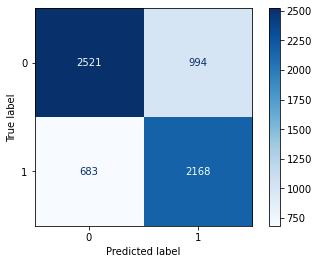

In [259]:
# View confusion matrix

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [260]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.7172119487908961


In [261]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

Sensitivity: 0.7604349351104875


In [262]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

Accuracy: 0.736569274269557


## Error Analysis [Type 1 and Type 2 Errors]

https://www.datasciencecentral.com/understanding-type-i-and-type-ii-errors/


### How many Type I errors [FALSE POSITIVE] are there?


In [263]:
fp

994

### How many Type II errors [FALSE NEGATIVE] are there?


In [264]:
fn

683

### Which error is worse (Type I vs Type II)?


## ROC Curve

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


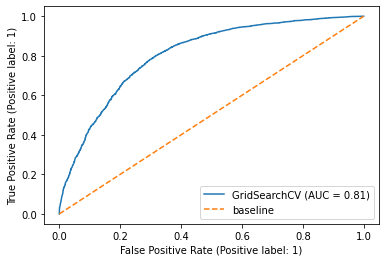

In [265]:
plot_roc_curve(gs, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

The area under the ROC curve measures the degree of overlap between the Specificity and Sensitivity distributions. Greater the area, the less overlap.

# DO I ACCEPT MORE FALSE POSITIVES OR FALSE NEGATIVES [BASED ON THE BUSNIESS CONTEXT]

---

# 1(b) Gridsearch with Count Vectorizer Hyperparameter Tuning


In [ ]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

In [83]:
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [84]:
rf_params2 = {
    #'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [0.05, 0.1],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5], # max_depth is the longest path
}
gs2 = GridSearchCV(pipe2, param_grid=rf_params2, cv=5) # USE PIPE2 INSTEAD

In [85]:
gs2.fit(X_train, y_train) # or X_train_df ?
print(gs2.best_score_)
gs2.best_params_

0.6152895066201174


{'cvec__max_df': 0.95,
 'cvec__min_df': 0.05,
 'cvec__ngram_range': (1, 1),
 'rf__max_depth': None,
 'rf__n_estimators': 150}

In [86]:
gs2.score(X_train, y_train)

0.6839213865676261

In [87]:
gs2.score(X_test, y_test) # or X_test_df ? 

0.6195413132265158

## BOOLEAN MASKING ON DATAFRAME 

WITH ACTUAL TEST TARGET AND PREDICTED VALUES TO FIND OUT THE FALSE POSITIVES AND FALSE NEGATIVES

In [124]:
preds2 = gs2.predict(X_test)

In [125]:
preds2 = pd.Series(preds2)

print(type(preds2))
preds2

<class 'pandas.core.series.Series'>


0       0
1       0
2       0
3       1
4       0
       ..
6361    0
6362    0
6363    0
6364    1
6365    1
Length: 6366, dtype: int64

In [126]:
print(type(X_test))

X_test.head()

<class 'pandas.core.series.Series'>


8406           traditional roth tax bracket actually lower
14781          daily general discussion advice thread july
7471     hi wondering would good place put pitch invest...
25723    bed bath amp beyond inc bbby one heavily short...
20041                               go well morning coffee
Name: Text, dtype: object

In [127]:
print(type(y_test))

y_test

<class 'pandas.core.series.Series'>


8406     0
14781    0
7471     0
25723    1
20041    1
        ..
13748    0
21637    1
20291    1
14025    0
22170    1
Name: subreddit, Length: 6366, dtype: int64

In [128]:
df2 = pd.concat([X_test, y_test], axis=1).reset_index()


In [129]:
df2 = pd.concat([df2, preds2], axis=1).reset_index()
# df.drop(['level_0','index'],axis=1, inplace=True)
df2

,level_0,index,Text,subreddit,0
0,0,8406,traditional roth tax bracket actually lower,0,0
1,1,14781,daily general discussion advice thread july,0,0
2,2,7471,hi wondering would good place put pitch invest...,0,0
3,3,25723,bed bath amp beyond inc bbby one heavily short...,1,1
4,4,20041,go well morning coffee,1,0
...,...,...,...,...,...
6361,6361,13748,drought hitting ca italy france hard,0,0
6362,6362,21637,needed become hedge fund manager analyst,1,0
6363,6363,20291,u gdp accelerated pace q better expected growt...,1,0
6364,6364,14025,rate portfolio individual stocks,0,1


In [131]:
false_positive_mask2 = (df2['subreddit']== 0)&(df2[0]== 1)
false_negative_mask2 = (df2['subreddit']== 1)&(df2[0]== 0)

### False Positives List

In [132]:
df2[false_positive_mask2]['Text']

5                             sensible place put year old
10      amazon demand problem amazon currently run sal...
14      anyone else think bonds looking undervalued fa...
27      cash roth holding gunpowder market bottoms try...
29                          general thoughts stock market
                              ...                        
6323    least amount effort make educated bet stock in...
6334                        market catalysts coming month
6336                       realized losses gains year far
6344    could help understand advice got bank stock po...
6364                     rate portfolio individual stocks
Name: Text, Length: 619, dtype: object

### False Negatives List

In [134]:
df2[false_negative_mask2]['Text']

4                                  go well morning coffee
21                      gacha characters mettaton kissing
22      two americans sent prison stealing crypto sim ...
23      wall street creates counterfeit shares amc gam...
24                                          buildtogether
                              ...                        
6352        twitter asks musk turn texts first six months
6353    letting financially literate folks test skills...
6355    cranium proof gifted gene gift god medici ethe...
6362             needed become hedge fund manager analyst
6363    u gdp accelerated pace q better expected growt...
Name: Text, Length: 1803, dtype: object

---

## Error Analysis [Type 1 and Type 2 Errors]

https://www.datasciencecentral.com/understanding-type-i-and-type-ii-errors/

In [135]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score


#### Gridsearch Accuracy

In [137]:
# Get predictions
preds2 = gs2.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [138]:
cm2 = confusion_matrix(y_test, preds)
cm2

array([[2896,  619],
       [1803, 1048]], dtype=int64)

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


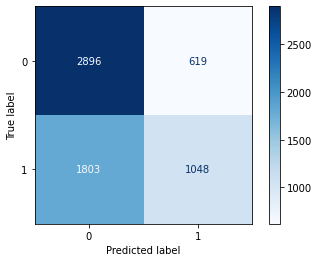

In [140]:
# View confusion matrix

plot_confusion_matrix(gs2, X_test, y_test, cmap='Blues', values_format='d');

In [141]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8238975817923186


In [142]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

Sensitivity: 0.36759031918625046


In [143]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

Accuracy: 0.6195413132265158


### How many Type I errors [FALSE POSITIVE] are there?


In [144]:
fp

619

### How many Type II errors [FALSE NEGATIVE] are there?


In [145]:
fn

1803

### Which error is worse (Type I vs Type II)?


c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


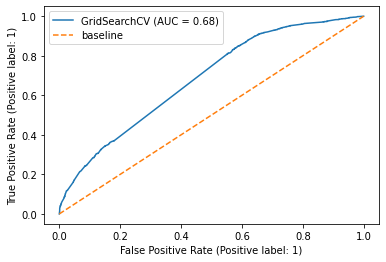

In [146]:
plot_roc_curve(gs2, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

---

# 1. Random Forest with TFID Vectorizer

In [166]:
# Let's set a pipeline up with two stages:
# 1. TFIDVectorizer (transformer)
# 2. Random Forest (estimator)

pipe3 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

## Reinstantiate Train and Test Data [Should I do this for random forest?]

To avoid error of instantiating/fitting count vectorizer down below [IMPORTANT]

In [167]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

In [96]:
cross_val_score(pipe3, X_train, y_train, cv=5)

array([0.75551257, 0.74235977, 0.72765957, 0.7450677 , 0.75580495])

In [152]:
# ii. Fit into model
pipe3.fit(X_train, y_train)

# Training score
print(pipe3.score(X_train, y_train))

0.9891674404209223


In [153]:
print(pipe3.score(X_test, y_test))

0.7516493873704053


## Gridsearch with TFID Vectorizer

In [154]:
# Instantiate a CountVectorizer with the default hyperparameters.
tvec = TfidfVectorizer()

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y, # stratify means the proportion of 0s and 1s are kept
                                                    random_state=42)

In [122]:
X_train = tvec.fit(X_train)
#tvec.transform(X_train) 

In [157]:
X_train = tvec.fit_transform(X_train) 

In [158]:
# convert training data to dataframe
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names()) # cvec is the CountVectorizer object

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [172]:
rf_params3 = {
    #'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__max_df': [0.9,0.95],
    'tvec__min_df':[0.05,0.1],
    'tvec__ngram_range': [(1,1), (1,2)], # what about min_df and max_df?
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5], # max_depth is the longest path
}
gs3 = GridSearchCV(pipe3, param_grid=rf_params3, cv=5)


https://stackoverflow.com/questions/44066264/how-to-choose-parameters-in-tfidfvectorizer-in-sklearn-during-unsupervised-clust

In [173]:
gs3.fit(X_train, y_train) # or X_train_df?

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [None, 1, 2, 3, 4, 5],
                         'rf__n_estimators': [100, 150, 200],
                         'tvec__max_df': [0.9, 0.95],
                         'tvec__min_df': [0.05, 0.1],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [175]:
print(gs3.best_score_)
gs3.best_params_

0.616140540508171


{'rf__max_depth': None,
 'rf__n_estimators': 100,
 'tvec__max_df': 0.9,
 'tvec__min_df': 0.05,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

Time: 69 min 8.9 s

In [176]:
gs3.score(X_train, y_train)

0.6740173320953265

In [177]:
gs3.score(X_test, y_test) # or X_test_df ? 

0.6214263273641218

## BOOLEAN MASKING ON DATAFRAME 

WITH ACTUAL TEST TARGET AND PREDICTED VALUES TO FIND OUT THE FALSE POSITIVES AND FALSE NEGATIVES

In [188]:
preds3 = gs3.predict(X_test)

In [189]:
preds3 = pd.Series(preds3)

print(type(preds3))
preds3

<class 'pandas.core.series.Series'>


0       0
1       0
2       0
3       1
4       0
       ..
6361    0
6362    0
6363    0
6364    1
6365    1
Length: 6366, dtype: int64

In [190]:
print(type(X_test))

X_test.head()

<class 'pandas.core.series.Series'>


8406           traditional roth tax bracket actually lower
14781          daily general discussion advice thread july
7471     hi wondering would good place put pitch invest...
25723    bed bath amp beyond inc bbby one heavily short...
20041                               go well morning coffee
Name: Text, dtype: object

In [191]:
df3 = pd.concat([X_test, y_test], axis=1).reset_index()


In [192]:
df3 = pd.concat([df3, preds3], axis=1).reset_index()
# df.drop(['level_0','index'],axis=1, inplace=True)
df3

,level_0,index,Text,subreddit,0
0,0,8406,traditional roth tax bracket actually lower,0,0
1,1,14781,daily general discussion advice thread july,0,0
2,2,7471,hi wondering would good place put pitch invest...,0,0
3,3,25723,bed bath amp beyond inc bbby one heavily short...,1,1
4,4,20041,go well morning coffee,1,0
...,...,...,...,...,...
6361,6361,13748,drought hitting ca italy france hard,0,0
6362,6362,21637,needed become hedge fund manager analyst,1,0
6363,6363,20291,u gdp accelerated pace q better expected growt...,1,0
6364,6364,14025,rate portfolio individual stocks,0,1


In [193]:
df3.drop(['level_0','index'],axis=1, inplace=True)
df3

,Text,subreddit,0
0,traditional roth tax bracket actually lower,0,0
1,daily general discussion advice thread july,0,0
2,hi wondering would good place put pitch invest...,0,0
3,bed bath amp beyond inc bbby one heavily short...,1,1
4,go well morning coffee,1,0
...,...,...,...
6361,drought hitting ca italy france hard,0,0
6362,needed become hedge fund manager analyst,1,0
6363,u gdp accelerated pace q better expected growt...,1,0
6364,rate portfolio individual stocks,0,1


In [194]:
false_positive_mask3 = (df3['subreddit']== 0)&(df3[0]== 1)
false_negative_mask3 = (df3['subreddit']== 1)&(df3[0]== 0)

In [195]:
df3[false_positive_mask3]['Text']

14      anyone else think bonds looking undervalued fa...
27      cash roth holding gunpowder market bottoms try...
29                          general thoughts stock market
30      business class investopedia game best stocks b...
42      batch single stocks feel confident future span...
                              ...                        
6334                        market catalysts coming month
6344    could help understand advice got bank stock po...
6345    watching youtuber go dividend portfolio mentio...
6354    work contributes think allowed contribute spon...
6364                     rate portfolio individual stocks
Name: Text, Length: 558, dtype: object

In [196]:
df3[false_negative_mask3]['Text']

4                                  go well morning coffee
7       tlry elon musk buys billion stake tlry inc htt...
21                      gacha characters mettaton kissing
22      two americans sent prison stealing crypto sim ...
23      wall street creates counterfeit shares amc gam...
                              ...                        
6352        twitter asks musk turn texts first six months
6353    letting financially literate folks test skills...
6355    cranium proof gifted gene gift god medici ethe...
6362             needed become hedge fund manager analyst
6363    u gdp accelerated pace q better expected growt...
Name: Text, Length: 1852, dtype: object

## Error Analysis [Type 1 and Type 2 Errors]

https://www.datasciencecentral.com/understanding-type-i-and-type-ii-errors/


In [178]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score


#### Gridsearch Accuracy

In [179]:
# Get predictions
preds = gs3.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [180]:
cm3 = confusion_matrix(y_test, preds)
cm3

array([[2957,  558],
       [1852,  999]], dtype=int64)

c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


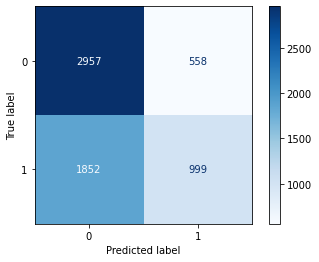

In [181]:
# View confusion matrix

plot_confusion_matrix(gs3, X_test, y_test, cmap='Blues', values_format='d');

In [182]:
# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8412517780938834


In [183]:
# Calculate the sensitivity

sens = tp/(tp+fn)

print('Sensitivity:', sens)

Sensitivity: 0.35040336723956506


In [184]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

print('Accuracy:', accuracy)

Accuracy: 0.6214263273641218


### How many Type I errors [FALSE POSITIVE] are there?


In [185]:
fp

558

### How many Type II errors [FALSE NEGATIVE] are there?


In [186]:
fn

1852

### Which error is worse (Type I vs Type II)?


c:\Users\redoc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


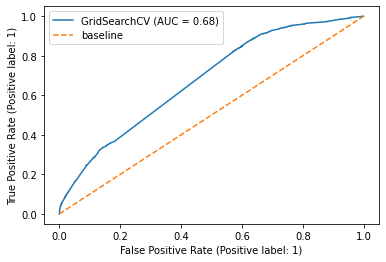

In [187]:
plot_roc_curve(gs3, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

The area under the ROC curve measures the degree of overlap between the Specificity and Sensitivity distributions. Greater the area, the less overlap.